# CASTOR UVMOS Spectrograph ETC Example With Your Own File (Exoplanet Science Case 1)

_Written by Jocelyn Roney - July 2025_

_With help from Dr. Tyrone Woods and Isaac Cheng_

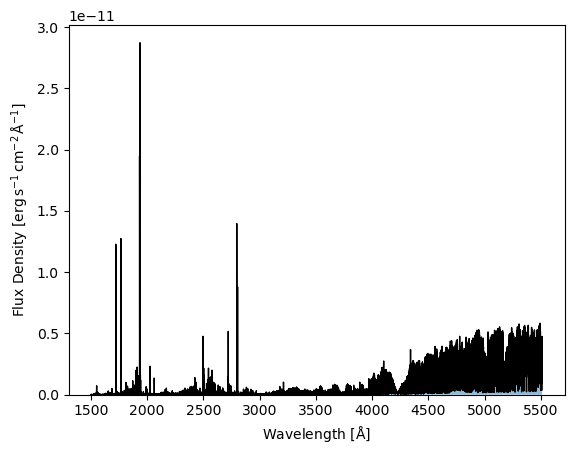

In [1]:
import matplotlib
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy import constants as const

from castor_etc.background import Background
from castor_etc.photometry import Photometry
from castor_etc.sources import ExtendedSource, GalaxySource, PointSource
from castor_etc.telescope import Telescope

from castor_etc.uvmos_spectroscopy import UVMOS_Spectroscopy

import pandas as pd
import matplotlib.pyplot as plt
import math 
plt.rcParams.update(plt.rcParamsDefault) #Used to make graphs on Visual Studio Code and matplotlib.pyplot
MyTelescope = Telescope()
MyTelescope.dark_current = 0.01 
MyBackground = Background()
df = pd.read_csv(r"C:\Users\jgron\OneDrive\Desktop\CASTOR Summer 2025\Example Notbook 650Myr_Median\650Myr_0.35M_Median.csv")
# Drop duplicates in 'Column1', keeping the first occurrence, this will also drop the attahced flux as well
df_no_duplicates = df.drop_duplicates(subset=['Wavelength (Ang)'], keep='first')
# Turns the two column df into two 1D arrays
wavelength = df_no_duplicates['Wavelength (Ang)'].to_numpy()
flux = df_no_duplicates['Flux Density (erg/cm2/s/Ang)'].to_numpy()
MySource = PointSource()
#My data had wavelength values from 0 Ang up to 55000 Ang. CASTORs bandwidth is from 1500 Ang to 5500 Ang.
#To reflect this, I sliced the index, these values may be different for you and your file.
MySource.set_spectrum(wavelengths = wavelength[94866:595683], spectrum = flux[94866:595683], unit = "flam")
MySource.norm_to_AB_mag(10)
MySource.show_spectrum()
MySpec = UVMOS_Spectroscopy(MyTelescope, MySource, MyBackground)
MySpec.specify_slit()



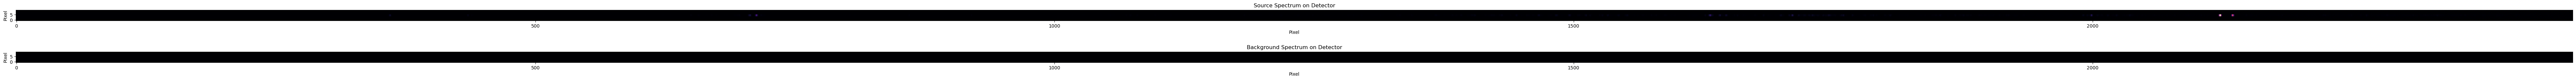

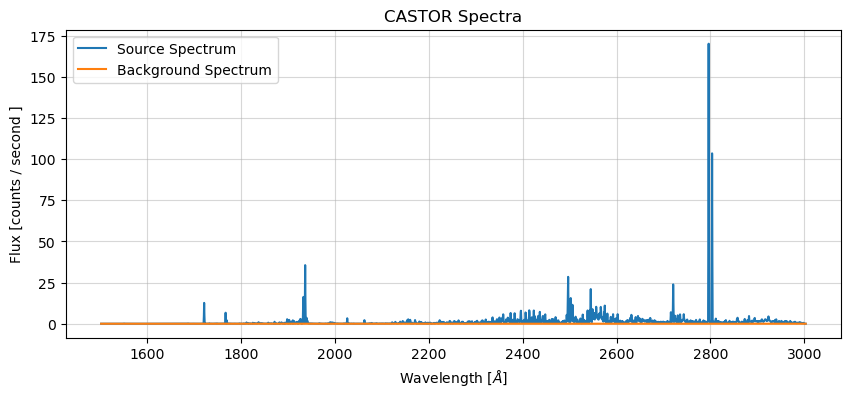

In [2]:
MySpec.calc_source_CASTORSpectrum(extraction_width=1, extraction_lowerlim=4, extraction_upperlim = 7)
MySpec.calc_background_CASTORSpectrum(extraction_width=1, extraction_lowerlim=4, extraction_upperlim = 7)


# Optional: Visualize the source and background spectra on the detector
plt.figure(figsize=(100,3))

ax1 = plt.subplot(211)
plt.imshow(MySpec.source_detector,origin='lower',cmap='magma',aspect='auto')
plt.title('Source Spectrum on Detector')
plt.xlabel('Pixel')
plt.ylabel('Pixel')
ax1.set_aspect('equal')


ax2 = plt.subplot(212, sharex=ax1, sharey=ax1)
plt.imshow(MySpec.background_detector*MySpec.source_extracted_numpixs,origin='lower',cmap='magma',aspect='auto', vmin=min(MySpec.source_detector.flatten()), vmax=max(MySpec.source_detector.flatten()))
plt.title('Background Spectrum on Detector')
plt.xlabel('Pixel')
plt.ylabel('Pixel')
ax2.set_aspect('equal')



# Optional: Visualize the source and background 
plt.figure(figsize=(10,4))
ax = plt.subplot(111)
plt.plot(MySpec.waves_CASTORSpectrum, MySpec.source_CASTORSpectrum,'-',label='Source Spectrum')

plt.plot(MySpec.waves_CASTORSpectrum, MySpec.background_CASTORSpectrum*MySpec.source_extracted_numpixs,'-',label='Background Spectrum')

plt.title('CASTOR Spectra')
plt.xlabel('Wavelength '+r'[$\AA$]')
plt.ylabel('Flux [counts / second ]')
plt.grid(alpha=0.5)
plt.legend()

This notebook will give another example on how to use CASTOR's UVMOS. This example uses a file with synthetic M star flare data of wavelength and flux. This was used to see how well CASTOR would be able to observe flares from dim M stars, how long it will take to reach a given Signal-to-Noise ratio, or what that ratio may be after a given amount of observing time.

In [ ]:
import matplotlib
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy import constants as const

from castor_etc.background import Background
from castor_etc.photometry import Photometry
from castor_etc.sources import ExtendedSource, GalaxySource, PointSource
from castor_etc.telescope import Telescope

from castor_etc.uvmos_spectroscopy import UVMOS_Spectroscopy

import pandas as pd
import matplotlib.pyplot as plt
import math 
plt.rcParams.update(plt.rcParamsDefault) #Used to make graphs on Visual Studio Code and matplotlib.pyplot

## Step 1) Describe the telescope

First specify the telescope parameters by creating a `Telescope` object. All aspects of the telescope are customizable. For the UVMOS-ETC, you may wish to change the the full width at half-maximum of the telescope's point spread function, the pixel scale, the dark current, or the read noise.

Ex) To initialize a `Telescope` object with a specific dark current:

MyTelescope = Telescope( dark_current = 0.01 )

Ex) To change the dark current of an existing `Telescope` object:

MyTelescope.dark_current = 0.01 

In [ ]:
MyTelescope = Telescope()
MyTelescope.dark_current = 0.01 
print('Mirror Area:  {:.3f}'.format( MyTelescope.mirror_area ))

print('Pixel Scale:  {:.3f}'.format( MyTelescope.px_scale ))

print('Pixel Area:  {:.3f}'.format( MyTelescope.px_area ))

print('Read Noise:   {:.3f}'.format( MyTelescope.read_noise ))

print('Dark Current  {:.3f}'.format( MyTelescope.dark_current ))

Mirror Area:  7853.982 cm2
Pixel Scale:  0.100 arcsec
Pixel Area:  0.010 arcsec2
Read Noise:   3.000
Dark Current  0.010


## Step 2) Characterize the background

By default, the `Background` object uses spectra from HST that give average Earthshine and zodiacal light values.

In [3]:
MyBackground = Background()

## Step 3) Read in the File

There are two ways that you can use your own data with the UVMOS.
1) `set_spectrum` requires you to load your data into two 1D arrays. The first array contains your wavelength data in Angstroms. The second array contains the flux data in erg/s/cm^2/A, erg/s/cm^2/Hz, AB magnitude, or ST magnitude. You must then specify which flux unit you chose with the key words listed in the function below. (I found it easiest to change my data into pandas dataframes then into two 1D arrays.)

   

2) `use_custom_spectrum` uses an ASCII or FITS file.

### Simulate the Source: Method 1)
Before reading in the data, make sure your file containing the wavelength and flux spectra is added to the same file that this code is saved too. I am using CANFAR so I have this Jupyter notebook and my data saved in the same file on the left hand side in the file folder tab, this file path being arc/home/your_user_name. I used pandas dataframes (df) to change my csv file into two 1D numpy arrays. You can also call the file from your desktop with the correct path and name of file as shown below.

In [ ]:
#Read csv file into df, my data is synthetic spectra from M stars with differnt flare intensities.

#If you are calling from Jupyter Notebook use the below, you may have to remove arc/home/your_username and just have the file name.
#df = pd.read_csv("arc/home/your_username/file_name")

#This is calling the file from my desktop for this you may need to change the \ to a /.
df = pd.read_csv(r"C:\Users\jgron\OneDrive\Desktop\CASTOR Summer 2025\Example Notbook 650Myr_Median\650Myr_0.35M_Median.csv")
print(df.head) #To see if it worked, it should print a few lines of your file.


#For the df function to work the titles of your columns must match 'Wavelength (Ang)' and 'Flux Density (erg/cm2/s/Ang)'
#If this is not the case change the titles below to reflect your column titles.
wavelength = df['Wavelength (Ang)'].to_numpy()
flux = df['Flux Density (erg/cm2/s/Ang)'].to_numpy()


###########################################################
#You may skip this section as my data had duplicate wavelengths which needed to be removed.

# Drop duplicates in 'Column1', keeping the first occurrence, this will also drop the attahced flux as well
#df_no_duplicates = df.drop_duplicates(subset=['Wavelength (Ang)'], keep='first')
# Turns the two column df into two 1D arrays
#wavelength = df_no_duplicates['Wavelength (Ang)'].to_numpy()
#flux = df_no_duplicates['Flux Density (erg/cm2/s/Ang)'].to_numpy()

###########################################################

<bound method NDFrame.head of         Wavelength (Ang)  Flux Density (erg/cm2/s/Ang)
0                100.100                      0.259298
1                100.200                      0.112798
2                100.300                      0.109169
3                100.400                      0.070892
4                100.500                      0.932395
...                  ...                           ...
764141         54996.728                   4988.844900
764142         54997.030                   5081.594400
764143         54997.130                   5140.436500
764144         54999.000                   5984.116000
764145         54999.783                   5470.159600

[764146 rows x 2 columns]>


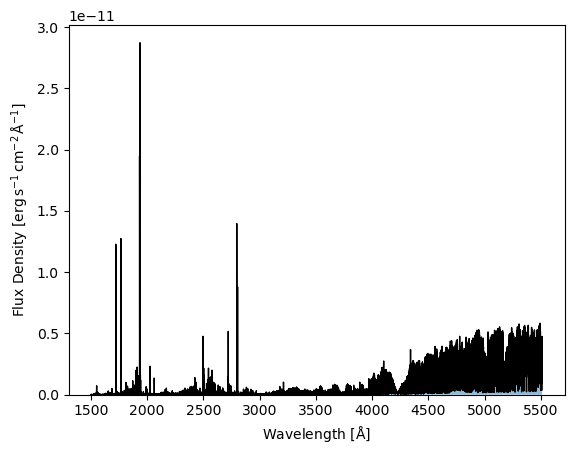

In [ ]:
#This function is found in the Castor Github under ETC=> castor_etc=> spectrum.py
def set_spectrum(self, wavelengths, spectrum, unit, overwrite=False, quiet=False):
        """
        Set the spectrum of the source based on the input arrays. To use a spectrum from a
        file, see the `use_custom_spectrum()` method.

        The input spectrum should have units of either flam (erg/s/cm^2/A), fnu
        (erg/s/cm^2/Hz), ABmag (AB magnitude), or STmag (ST magnitude). Note that the
        computed (and stored) spectrum will always be in units of flam.

        Parameters
        ----------
          wavelengths :: array of scalars or `astropy.Quantity` array
            The wavelengths over which to generate the uniform spectrum. If an array of
            scalars, it should be in angstrom. This should be a 1D array with the same
            length as the `spectrum` array.

          specturm :: array of scalars
            The value of the spectrum at the given wavelengths, in units of `unit`. This
            should be a 1D array with the same length as the `wavelengths` array.

          unit :: "flam" or "fnu" or "ABmag" or "STmag"
            The unit of the `spectrum` array: either flam (erg/s/cm^2/A), fnu
            (erg/s/cm^2/Hz), ABmag (AB magnitude), or STmag (ST magnitude).

          overwrite :: bool
            If True, overwrite any existing wavelengths/spectrum. If False, raise an error
            if wavelengths or spectrum is not None.

          quiet :: bool
            If True, do not print a message when overwriting an existing spectrum.

        Attributes
        ----------
          wavelengths :: astropy.Quantity` array
            The given wavelengths of the spectrum, converted into units of angstrom.

          spectrum :: array of floats
            The given spectrum, converted into units of erg/s/cm^2/A.

        Returns
        -------
          None
        """
        #
        # Check inputs
        #
        self._check_existing_spectrum(overwrite, quiet=quiet)
        if not isinstance(wavelengths, u.Quantity):
            wavelengths = wavelengths * u.AA
        else:
            wavelengths = wavelengths.to(u.AA)
        if isinstance(spectrum, u.Quantity):
            raise TypeError("`spectrum` must be an array of scalars")
        if np.shape(spectrum) != np.shape(wavelengths) or np.ndim(spectrum) != 1:
            raise ValueError(
                "`wavelengths` and `spectrum` must be 1D arrays of the same shape"
            )
        if unit not in ["flam", "fnu", "ABmag", "STmag"]:
            raise ValueError("`unit` must be one of 'flam', 'fnu', 'ABmag', or 'STmag'")
        if unit == "flam" or unit == "fnu":
            if np.any(spectrum) <= 0:
                raise ValueError(
                    "All `spectrum` values must be > 0 if `unit` is 'flam' or 'fnu'"
                )
        #
        # Convert spectrum to units of flam (erg/s/cm^2/A)
        #
        if unit == "fnu":
            spectrum = fnu_to_flam(
                fnu=spectrum, wavelength=wavelengths, fnu_err=0.0, wavelength_err=0.0
            )[0]
        elif unit == "ABmag":
            # Convert to fnu
            spectrum = mag_to_flux(mag=spectrum, mag_err=0.0, zpt=-48.60)[0]
            # Convert fnu to flam
            spectrum = fnu_to_flam(
                fnu=spectrum, wavelength=wavelengths, fnu_err=0.0, wavelength_err=0.0
            )[0]
        elif unit == "STmag":
            # Convert directly to flam
            spectrum = mag_to_flux(mag=spectrum, mag_err=0.0, zpt=-21.10)[0]
        self.wavelengths = wavelengths
        self.spectrum = spectrum


MySource = PointSource()
#My data had wavelength values from 0 Ang up to 55000 Ang. CASTORs bandwidth is from 1500 Ang to 5500 Ang.
#To reflect this, I sliced the index, these values may be different for you and your file.
MySource.set_spectrum(wavelengths = wavelength[94866:595683], spectrum = flux[94866:595683], unit = "flam")
MySource.norm_to_AB_mag(10)
MySource.show_spectrum()

### Simulate the Source: Method 2)
This method requires your file be in ASCII or FITS file format. The ASCII and FITS must have wavelength in either angstrom, nanomenter or micrometer, just specify which unit when calling the function. Flux must be in erg/s/cm^2/A. 

In [ ]:
#This function is found in the Castor Github under ETC=> castor_etc=> spectrum.py
def use_custom_spectrum(
        self, filepath, wavelength_unit=u.AA, overwrite=False, quiet=False
    ):
        """
        Use custom spectrum from an ASCII or FITS file. To use a spectrum from an array,
        use the `set_spectrum()` method.

        Parameters
        ----------
          filepath :: str
            The absolute path to the file containing the spectrum.
            If the file is in ASCII format, the first column should contain the
            wavelengths in `wavelength_units` and the second column containing the
            spectrum in flam (erg/s/cm^2/A); the columns should be separated by a constant
            number of spaces. Lines starting with a hash (#) will be ignored. The file
            extension must not be .fit or .fits.
            If the file is in FITS format, the first field (index 0) should contain the
            wavelengths in `wavelength_units` and the second field (index 1) should
            contain the spectrum in flam (erg/s/cm^2/A). The file extension must be .fit
            or .fits.

          wavelength_unit :: `astropy.Quantity` length unit
            The unit of the wavelengths in the file (e.g., u.AA for angstrom, u.nm for
            nanometer, u.um for micrometer, etc.)

          overwrite :: bool
            If True, overwrite any existing wavelengths/spectrum. If False, raise an error
            if wavelengths or spectrum is not None.

          quiet :: bool
            If True, do not print a message when overwriting an existing spectrum.

        Attributes
        ----------
          wavelengths :: `astropy.Quantity` array
            The wavelengths of the spectrum, in angstroms.

          spectrum :: array of floats
            Source spectrum in units of flam (erg/s/cm^2/A).

        Returns
        -------
          None
        """
        #
        # Check inputs
        #
        self._check_existing_spectrum(overwrite, quiet=quiet)
        if not isinstance(filepath, str):
            raise TypeError("filepath must be a string.")
        try:
            _ = wavelength_unit.to(u.AA)
        except Exception:
            raise TypeError("wavelength_units must be an `astropy.Quantity` length unit.")
        #
        # Load spectrum
        #
        file_ext = filepath.split(".")[-1].lower()
        try:
            if file_ext == "fit" or file_ext == "fits":
                data = fits.getdata(filepath)
                self.wavelengths = (data.field(0)[0] * wavelength_unit).to(u.AA)
                # Dhananjhay's comment for `data.field(1)` below - index 0 to access the
                # corresponding arrays; data variable contains embedded arrays
                self.spectrum = data.field(1)[0]
            else:
                data = pd.read_csv(
                    filepath,
                    sep=r"\s+",
                    header=None,
                    comment="#",
                    engine="python",
                )  # sep=" +" is Python regex to match a variable number of spaces
                self.wavelengths = (data[0].values * wavelength_unit).to(u.AA)
                self.spectrum = data[1].values
        except Exception:
            raise RuntimeError(
                "Could not read spectrum from file. File must be in ASCII or FITS format "
                + "and adhere to the guidelines specified in the docstring."
            )


# file_path = "your_file_name.txt"
# MySource = PointSource()
# MySource.use_custom_spectrum(file_path, wavelengt_unit = u.AA, overwrite=False, quiet=False)
# MySource.norm_to_AB_mag(10)
# MySource.show_spectrum()

## Step 5) Do Spectroscopy

In [7]:
#Create Spectroscopy object
MySpec = UVMOS_Spectroscopy(MyTelescope, MySource, MyBackground)

By default, the spectral range of is set to be 150nm to 300nm. This may be changed by setting `MySpec.min_wave` or `MySpec.max_wave` to some number with a wavelength unit in angstroms. 

For example:
```Python
MySpec.min_wave = (150 * u.nm).to(u.AA)
MySpec.max_wave = (300 * u.nm).to(u.AA)
```


In order to do slit spectroscopy, a slit must be chosen.
By default, a slit with a width of 0.214" and height of 1" is used. Change the slit width and / or height.

For example: 
```Python
MySpec.specify_slit(slit_width = 0.15 * u.arcsec, slit_height = 0.5 * u.arcsec   )
```

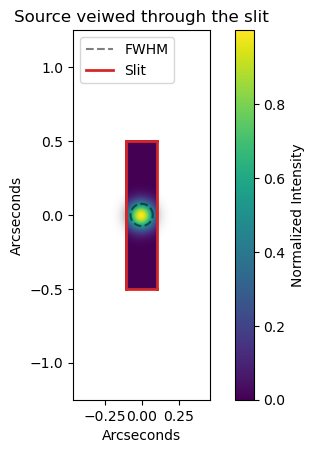

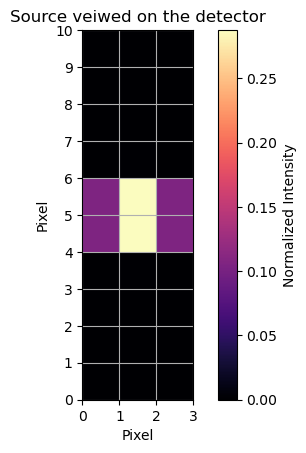

In [8]:
# Specify the slit
MySpec.specify_slit()

# Optional: Show the source as viewed through the slit
MySpec.show_slit()

# Optional: Show a single image of the slit on the detector
MySpec.show_source_pix_weights()

By default, the extraction box is set to a width of 1 pixel along the wavelength axis, and extends along the entire spatial axis. The extraction box may be changed by passing the desired values to calculate CASTOR spectra functions. 

For example:
```Python
MySpec.calc_source_CASTORSpectrum(extraction_width=2, extraction_lowerlim=4, extraction_upperlim = 7)
```

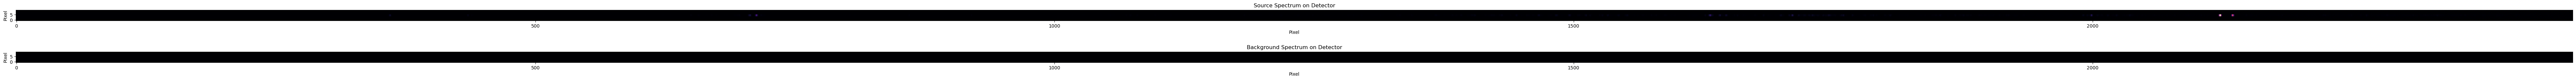

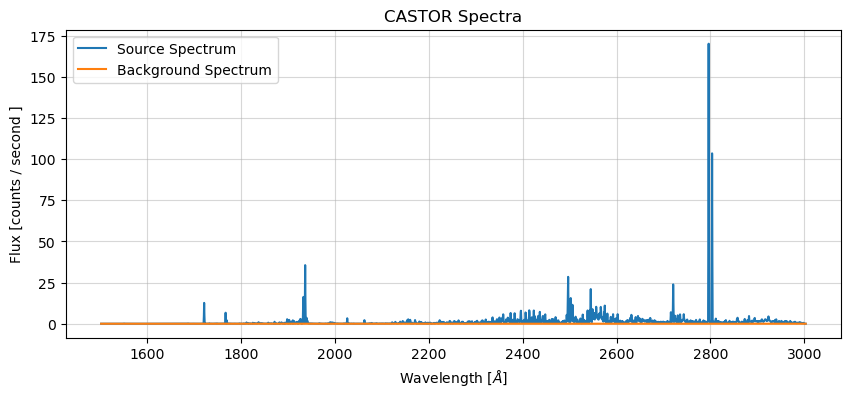

In [9]:
MySpec.calc_source_CASTORSpectrum(extraction_width=1, extraction_lowerlim=4, extraction_upperlim = 7)
MySpec.calc_background_CASTORSpectrum(extraction_width=1, extraction_lowerlim=4, extraction_upperlim = 7)


# Optional: Visualize the source and background spectra on the detector
plt.figure(figsize=(100,3))

ax1 = plt.subplot(211)
plt.imshow(MySpec.source_detector,origin='lower',cmap='magma',aspect='auto')
plt.title('Source Spectrum on Detector')
plt.xlabel('Pixel')
plt.ylabel('Pixel')
ax1.set_aspect('equal')


ax2 = plt.subplot(212, sharex=ax1, sharey=ax1)
plt.imshow(MySpec.background_detector*MySpec.source_extracted_numpixs,origin='lower',cmap='magma',aspect='auto', vmin=min(MySpec.source_detector.flatten()), vmax=max(MySpec.source_detector.flatten()))
plt.title('Background Spectrum on Detector')
plt.xlabel('Pixel')
plt.ylabel('Pixel')
ax2.set_aspect('equal')



# Optional: Visualize the source and background 
plt.figure(figsize=(10,4))
ax = plt.subplot(111)
plt.plot(MySpec.waves_CASTORSpectrum, MySpec.source_CASTORSpectrum,'-',label='Source Spectrum')

plt.plot(MySpec.waves_CASTORSpectrum, MySpec.background_CASTORSpectrum*MySpec.source_extracted_numpixs,'-',label='Background Spectrum')

plt.title('CASTOR Spectra')
plt.xlabel('Wavelength '+r'[$\AA$]')
plt.ylabel('Flux [counts / second ]')
plt.grid(alpha=0.5)
plt.legend()
#plt.savefig('650Myr_0.35M_Minimum.png')

## Determine Exposure Time and Signal-to-Noise Ratio

When determining the SNR keep in mind the object you are looking at, for bright objects a lower SNR is fine. For this notebook my data is synthetic M dwarf star flare data. These are very dim objects and require a much larger SNR of 50-100. You also want to have some knowledge of what wavelength to look at. For M stars, Mg II k and h are the strongest emmision lines seen in the UV so I have chosen them as my 'wave' value. If you choose a wave that is not present in the 'CASTOR Spectra' above you will have very poor SNR values.

**650 Myr 0.35 Solar Masses: Determine Exposure time for Mg II k or 2803.53 Angstrum**


In [10]:
t = 100 # seconds
wave = 2803.53 # angstroms
snr = MySpec.calc_snr_from_t(t, wave)
print('After an exposure time of {:.3f} seconds a SNR of {:.3f} is reached at a wavelength of {} angstroms'.format(t,snr, wave))

After an exposure time of 100.000 seconds a SNR of 30.305 is reached at a wavelength of 2803.53 angstroms


In [11]:
snr = 50  
wave = 2803.53 # angstroms
t = MySpec.calc_t_from_snr(snr, wave)
print('An exposure time of {:.3g} seconds is required to reach a SNR of {:.3f} at a wavelength of {} angstroms'.format(t,snr, wave))

An exposure time of 1.22e+03 seconds is required to reach a SNR of 50.000 at a wavelength of 2803.53 angstroms


**650 Myr 0.35 Solar Masses: Determine Exposure time for Mg II h or 2796.35 Angstrum**

In [12]:
t = 100 # seconds
wave = 2796.35 # angstroms
snr = MySpec.calc_snr_from_t(t, wave)
print('After an exposure time of {:.3f} seconds a SNR of {:.3f} is reached at a wavelength of {} angstroms'.format(t,snr, wave))

After an exposure time of 100.000 seconds a SNR of 49.905 is reached at a wavelength of 2796.35 angstroms


In [13]:
snr = 50  
wave = 2796.35 # angstroms
t = MySpec.calc_t_from_snr(snr, wave)
print('An exposure time of {:.3g} seconds is required to reach a SNR of {:.3f} at a wavelength of {} angstroms'.format(t,snr, wave))

An exposure time of 193 seconds is required to reach a SNR of 50.000 at a wavelength of 2796.35 angstroms
